In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import umap.plot

# Process data

In [30]:
DATA_DIR = "data/"
RANDOM_SEED = 42
sampled_data = pd.read_parquet(DATA_DIR + "sampled_traffic.parquet")

In [31]:
# Get columns with only one unique value
for col in sampled_data.columns:
    if sampled_data[col].value_counts().count() == 1:
        print(f"\"{col}\",")

"Protocol",
"Bwd PSH Flags",
"Fwd URG Flags",
"Bwd URG Flags",
"URG Flag Count",
"Fwd Bytes/Bulk Avg",
"Fwd Packet/Bulk Avg",
"Fwd Bulk Rate Avg",


In [32]:
not_useful_columns = [
    "Flow ID",
    "Timestamp",
    "Src IP",
    "Dst IP",
    # Only 1 value
    "Protocol",
    "Bwd PSH Flags",
    "Fwd URG Flags",
    "Bwd URG Flags",
    "Fwd Bytes/Bulk Avg",
    "Fwd Packet/Bulk Avg",
    "Fwd Bulk Rate Avg",
    # "Attack Name",
    # Somewhat redundant with mean and std
    "Fwd Packet Length Max",
    "Fwd Packet Length Min",
    "Bwd Packet Length Max",
    "Bwd Packet Length Min",
    "Flow IAT Max",
    "Flow IAT Min",
    "Fwd IAT Max",
    "Fwd IAT Min",
    "Bwd IAT Max",
    "Bwd IAT Min",
    "Packet Length Min",
    "Packet Length Max",
    "Packet Length Variance",
    "Active Max",
    "Active Min",
    "Idle Max",
    "Idle Min",
    # Have more granular forward and backward counts 
    "PSH Flag Count",
    "URG Flag Count", # Only 1 value
    # Not a really informative metric
    "Fwd Header Length",
    "Bwd Header Length",
    # Subflows are likely too granular for our analysis
    "Subflow Fwd Packets",
    "Subflow Fwd Bytes",
    "Subflow Bwd Packets",
    "Subflow Bwd Bytes",
]

processed_data = sampled_data.drop(columns=not_useful_columns, axis=1)

In [33]:
print(f"Total number of features (including Label and Attack Name) after processing: {processed_data.shape[1]}")

Total number of features (including Label and Attack Name) after processing: 49


In [34]:
processed_data.to_parquet(DATA_DIR + "processed_traffic.parquet", index=False)

# Correlation Matrix

Looking below, there seems to be quite a few features that are especially negatively correlated with the label. One that stands out is Flow Duration, with lower values being correlated to malicious traffic. This could be in part to DoS and DDoS attacks having many packets sent with each transmission not lasting long. Interestingly, there is not as strong of a correlation for Flow Bytes/s or Flow Packets/s, but this could be because of different attacks in the malicious section of the data which exist different characteristics.

In [28]:
corr_matrix = processed_data.drop(columns=["Attack Name"]).corr() # since Attack Name is a string
pd.set_option('display.max_rows', None)  # To display all rows if there are many columns
pd.DataFrame(corr_matrix.sort_values(by="Label", ascending=False)["Label"])

,Label
Label,1.000000
RST Flag Count,0.484700
Dst Port,0.285067
SYN Flag Count,0.244469
FIN Flag Count,0.087325
FWD Init Win Bytes,0.085527
Total Bwd packets,0.084837
ACK Flag Count,0.083235
Total Fwd Packet,0.081312
Bwd Packet/Bulk Avg,0.079419


# Visualizations

## Features vs. Label

Looking at the below plot, we can see that there's some clear differences between benign and malicious traffic for some features which can suggest that those could be important predictors.

Generated plot
![](./images/feature_vs_label.png)

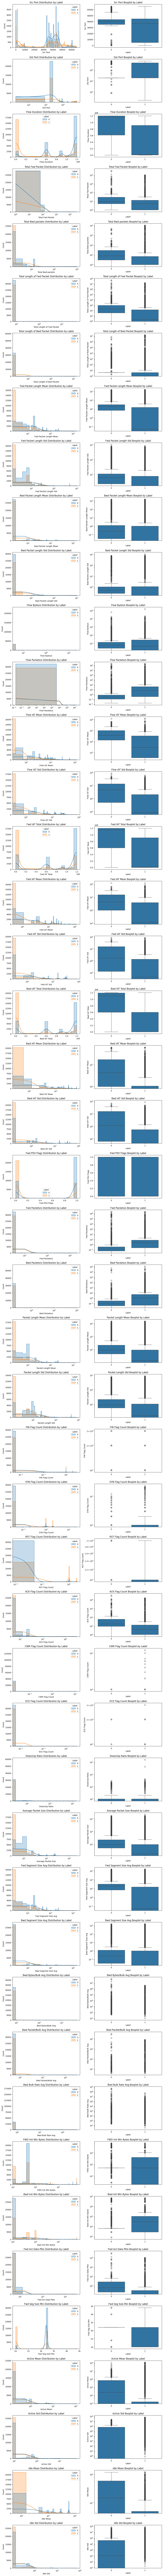

In [6]:
# List only the features you want to plot
features = [col for col in processed_data.columns 
            if col not in ["Label", "Attack Name"]]

# Create subplot grid
fig, axes = plt.subplots(len(features), 2, figsize=(12, len(features) * 4))

for i, feature in enumerate(features):

    # Histogram / distribution
    sns.histplot(
        data=processed_data,
        x=feature,
        hue="Label",
        kde=True,
        element="step",
        ax=axes[i, 0]
    )
    axes[i, 0].set_title(f"{feature} Distribution by Label")

    # Boxplot
    sns.boxplot(
        data=processed_data,
        x="Label",
        y=feature,
        ax=axes[i, 1]
    )
    axes[i, 1].set_title(f"{feature} Boxplot by Label")

    # Auto log scale for highly skewed features
    if processed_data[feature].max() > processed_data[feature].median() * 20:
        axes[i, 0].set_xscale("log")
        axes[i, 1].set_yscale("log")

plt.tight_layout()
plt.show()

## UMAP

We can see that there's overlap between some malicious and benign traffic which indicate it may not be as clear of a difference as expected.

Generated plot
![](./images/umap.png)

In [ ]:
reducer = umap.UMAP(random_state=RANDOM_SEED)
mapper = reducer.fit(
    processed_data.drop(columns=["Label", "Attack Name"])
)

/home/chunkanglu/Documents/School/Fall 2025/CSCC11/Project/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/chunkanglu/Documents/School/Fall 2025/CSCC11/Project/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<Axes: >

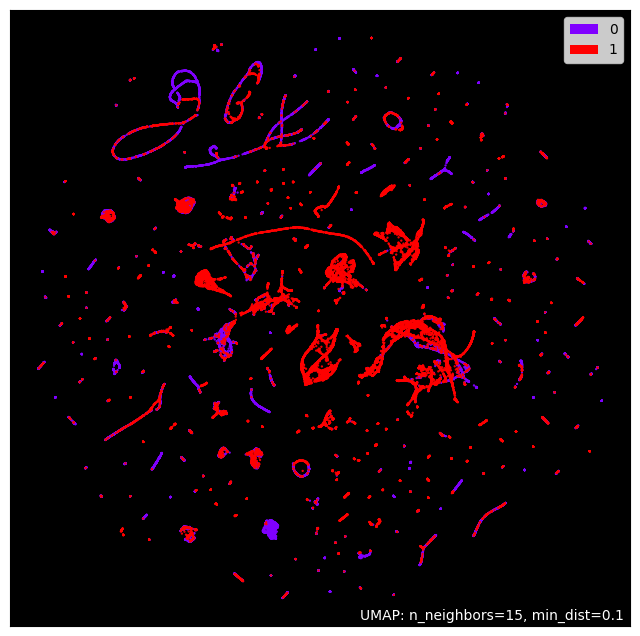

In [21]:
umap.plot.points(mapper, labels=processed_data["Label"], theme='fire')